# 1. Problemin Tanımı
Bu çalışma, bir şirketin geçmiş hisse fiyat verilerini veya kurun kullanarak gelecekteki fiyatını tahmin etmeyi amaçlar. LSTM tabanlı bir model kullanılacaktır.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (16, 9)

# 2. Veri Yükleme ve İnceleme (EDA)

İlk 5 Satır:
  Date    Adj Close        Close         High          Low         Open  \
0  NaT  2040.000000  2040.000000  2041.099976  2039.199951  2040.800049   
1  NaT  2039.300049  2039.300049  2040.900024  2038.000000  2040.000000   
2  NaT  2040.400024  2040.400024  2041.000000  2039.000000  2039.300049   
3  NaT  2043.000000  2043.000000  2043.800049  2039.800049  2040.400024   
4  NaT  2043.699951  2043.699951  2046.199951  2042.000000  2043.000000   

   Volume  
0       0  
1    3552  
2    2382  
3   10278  
4    9454  

Veri Boyutu: (5652, 7)

Veri Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5652 entries, 0 to 5651
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       0 non-null      datetime64[ns]
 1   Adj Close  5652 non-null   float64       
 2   Close      5652 non-null   float64       
 3   High       5652 non-null   float64       
 4   Low        5652 non-null   float

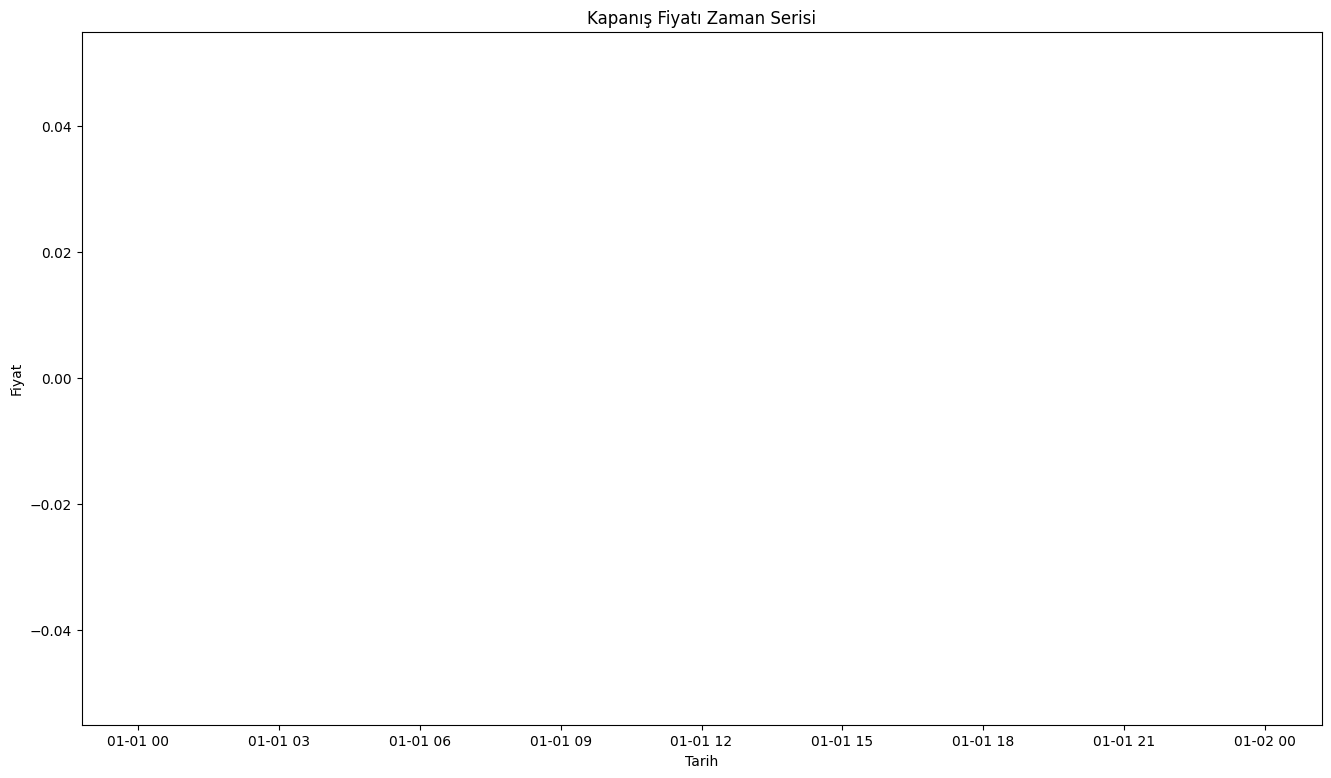


İstatistiksel Özellikler:
count    5652.000000
mean     2383.745418
std       229.878072
min      1999.900024
25%      2175.899902
50%      2374.699951
75%      2582.024902
max      2800.300049
Name: Close, dtype: float64


In [13]:
file_path = 'XAUUSD_data.csv'  # Dosya yolunuzu belirtin.
df = pd.read_csv(file_path)

# Tarihi datetime formata çevir
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Tarihe göre sırala
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# Veri önizleme
print("İlk 5 Satır:")
print(df.head())
print("\nVeri Boyutu:", df.shape)
print("\nVeri Bilgisi:")
print(df.info())
print("\nEksik Veri Sayısı:")
print(df.isnull().sum())

# Fiyat zaman serisi grafiği
plt.title("Kapanış Fiyatı Zaman Serisi")
plt.plot(df['Date'], df['Close'])
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.show()

print("\nİstatistiksel Özellikler:")
print(df['Close'].describe())

# 3. Ön İşleme (Data Preprocessing)
Eksik değer yok varsayımıyla devam ediyoruz.
Sadece 'Close' sütununu kullanacağız.

In [14]:
for i in range(1, len(df['Close']) - 1):
    if np.isnan(df['Close'][i]):
        df.loc[i, 'Close'] = np.nanmean([df['Close'][i - 1], df['Close'][i + 1]])

fiyat = df['Close'].values.reshape(-1, 1)

# 4. Feature Engineering (Özellik Mühendisliği)
Ekstra özellik eklemiyoruz.

In [15]:
# Ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(fiyat)

def dataset_olustur(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100

# 5. Eğitim-Test Ayrımı (Train-Test Split)

In [16]:
train_size = int(len(scaled_prices) * 0.8)
test_size = len(scaled_prices) - train_size
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

X_train, y_train = dataset_olustur(train_data, time_step)
X_test, y_test = dataset_olustur(test_data, time_step)

# LSTM girişi 3 boyutlu: [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Eğitim veri boyutu:", X_train.shape, y_train.shape)
print("Test veri boyutu:", X_test.shape, y_test.shape)

Eğitim veri boyutu: (4420, 100, 1) (4420,)
Test veri boyutu: (1030, 100, 1) (1030,)


# 6. Model Kurulumu

In [17]:
def create_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model()

c:\Users\ylmz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 7. Model Eğitimi ve Doğrulaması (Validation)
EarlyStopping ile durdurma. Burada patience=5 kullanıyoruz.

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0217 - val_loss: 0.0087
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0365 - val_loss: 0.0050
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0224 - val_loss: 6.0361e-04
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0133 - val_loss: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0023 - val_loss: 4.4193e-04
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0013 - val_loss: 3.5117e-04
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0024 - val_loss: 1.5986e-04
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0012 - val_loss: 1.4367e-04
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0016 - val_loss: 2.1844e-04
Epoch 12/100
70/70 

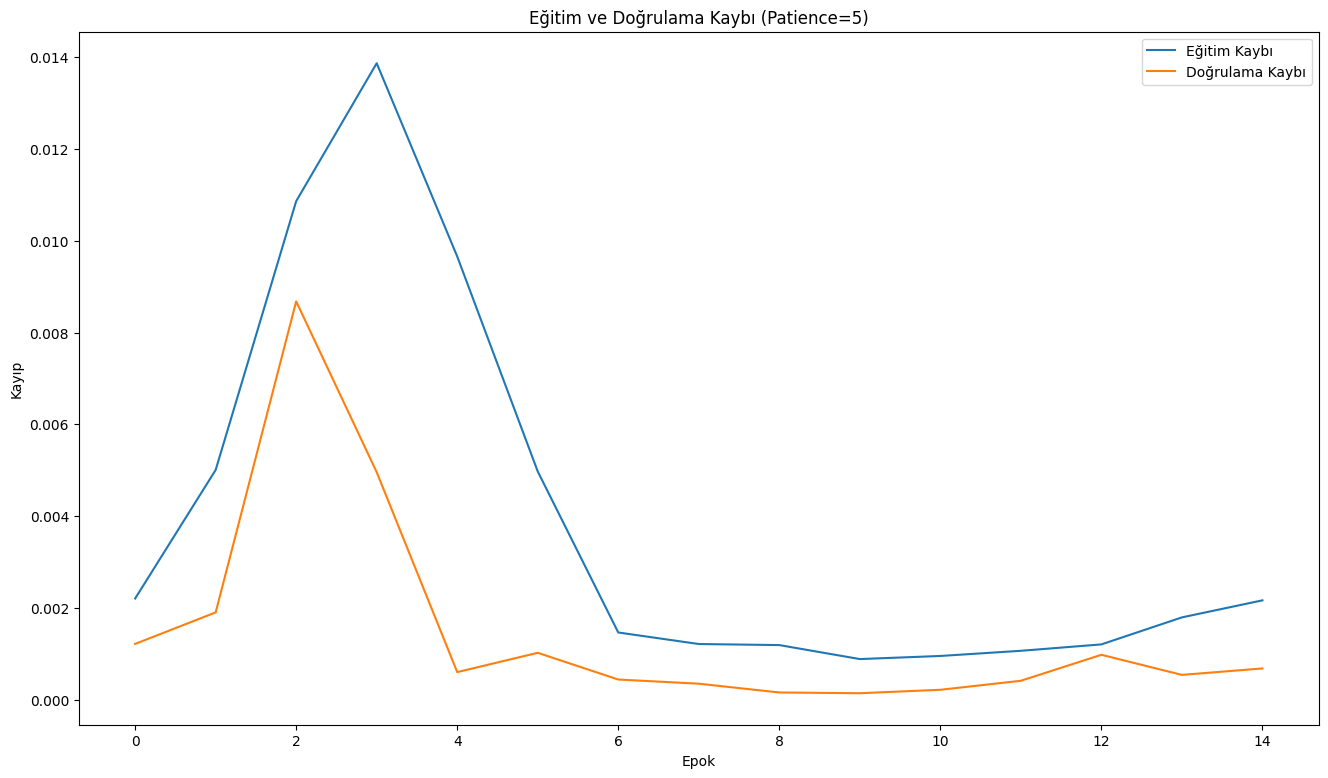

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=100,
    batch_size=64, 
    validation_data=(X_test, y_test), 
    shuffle=False, 
    callbacks=[early_stop],
    verbose=1
)

# Eğitim sürecinin kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı (Patience=5)')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# 8. Değerlendirme (Evaluation)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


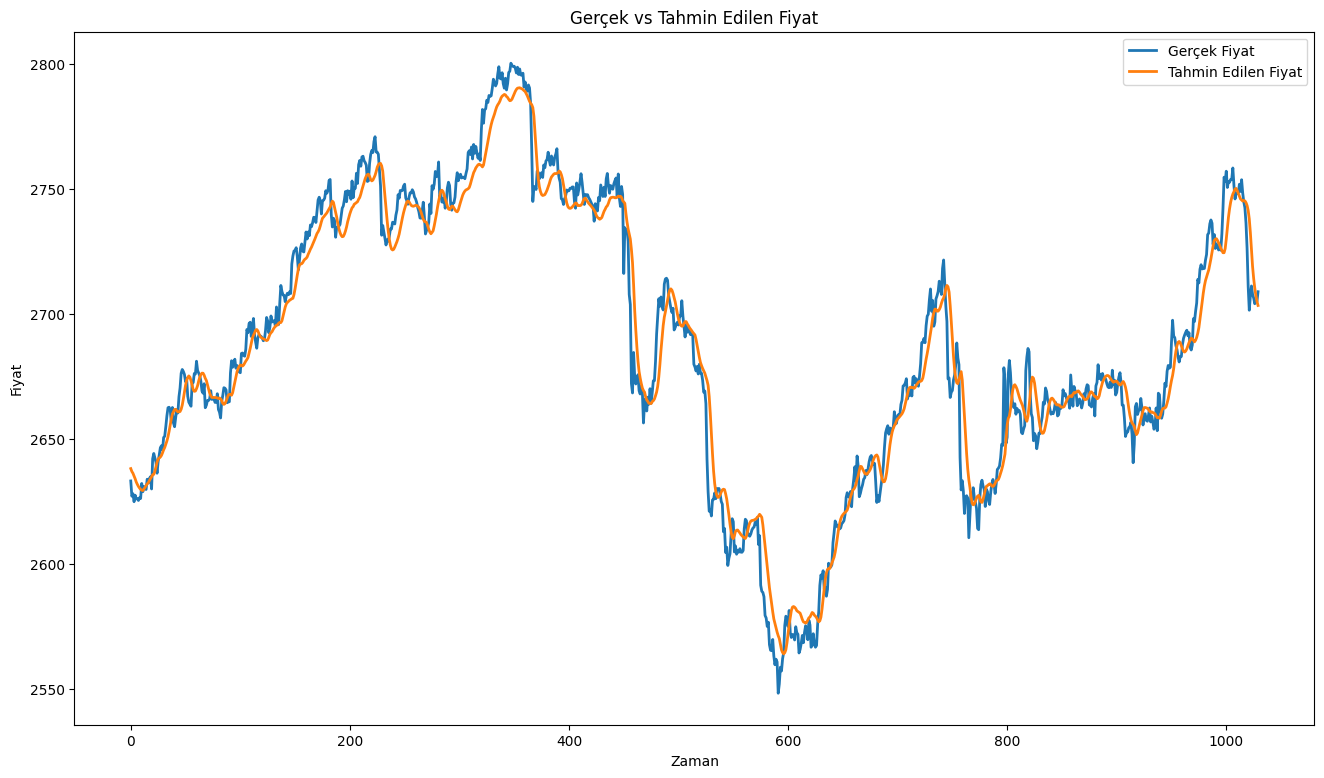

MAE: 8.131991429004854
RMSE: 10.974876916787938
MAPE: 0.30276769982953977 %


In [19]:
fiyat_tahmini = model.predict(X_test)
fiyat_tahmini = scaler.inverse_transform(fiyat_tahmini)
gercek_fiyat = scaler.inverse_transform(test_data[time_step+1:])

plt.plot(gercek_fiyat, label='Gerçek Fiyat', linewidth=2)
plt.plot(fiyat_tahmini, label='Tahmin Edilen Fiyat', linewidth=2)
plt.title('Gerçek vs Tahmin Edilen Fiyat')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

mae = mean_absolute_error(gercek_fiyat, fiyat_tahmini)
mse = mean_squared_error(gercek_fiyat, fiyat_tahmini)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((gercek_fiyat - fiyat_tahmini) / gercek_fiyat)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

# 9. Gelecek Tahminleri (Deployment/Future Predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

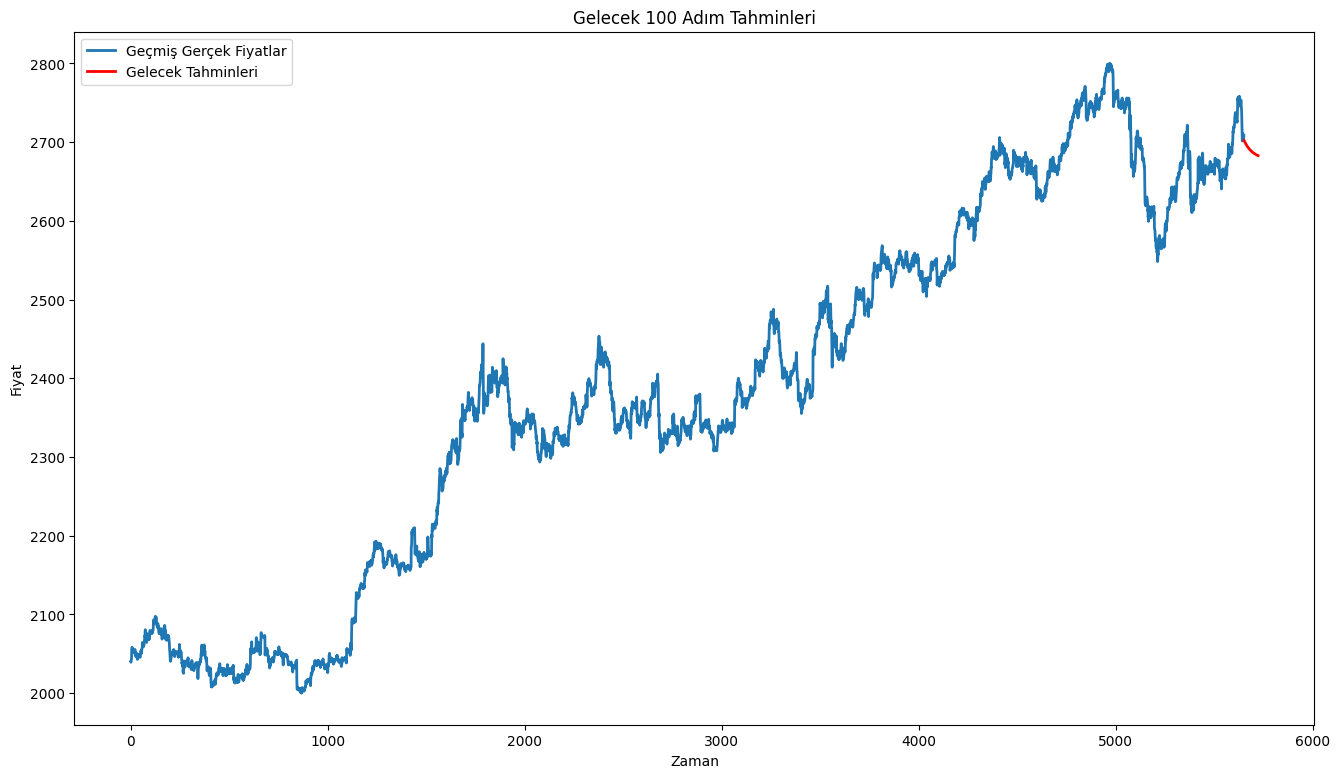

Sonraki 100 adım tahminleri: [2702.1897 2701.8015 2701.3071 2700.7764 2700.2417 2699.7163 2699.2053
 2698.7104 2698.2314 2697.7678 2697.319  2696.884  2696.462  2696.0522
 2695.6538 2695.2659 2694.8882 2694.5195 2694.1602 2693.809  2693.4658
 2693.1304 2692.8025 2692.4817 2692.1675 2691.8604 2691.5596 2691.2654
 2690.977  2690.6948 2690.419  2690.1484 2689.8835 2689.6243 2689.3706
 2689.1218 2688.8784 2688.6401 2688.4067 2688.178  2687.954  2687.7346
 2687.52   2687.3098 2687.1038 2686.9023 2686.7048 2686.5112 2686.322
 2686.1365 2685.955  2685.777  2685.603  2685.4324 2685.2654 2685.1018
 2684.9417 2684.785  2684.6313 2684.481  2684.3335 2684.1892 2684.048
 2683.9097 2683.7742 2683.6418 2683.512  2683.3845 2683.2603 2683.1382
 2683.0188 2682.9019]


In [22]:
son_girdi = scaled_prices[-time_step:]
tahminler = []

for _ in range(72):
    tahmin = model.predict(son_girdi.reshape(1, time_step, 1))
    tahminler.append(tahmin[0, 0])
    son_girdi = np.append(son_girdi[1:], tahmin, axis=0)


tahmin_edilen_degerler = scaler.inverse_transform(np.array(tahminler).reshape(-1, 1))
orijinal_fiyatlar = scaler.inverse_transform(scaled_prices)

gelecek_adimlar = list(range(len(orijinal_fiyatlar), len(orijinal_fiyatlar) + 72))

plt.plot(orijinal_fiyatlar, label='Geçmiş Gerçek Fiyatlar', linewidth=2)
plt.plot(gelecek_adimlar, tahmin_edilen_degerler, label='Gelecek Tahminleri', color='red', linewidth=2)
plt.title('Gelecek 100 Adım Tahminleri')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

print("Sonraki 100 adım tahminleri:", tahmin_edilen_degerler.flatten())